# Business Data Analytics Project

## First steps - importing libraries and reading the file


In [70]:
!pip install --upgrade gspread google-auth-httplib2 google-auth-oauthlib

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# Open GSheet by URL
worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1NVzwcDDxE7SlUDxQps7TKRUG35KtAg2eoKiIJxGMwyc/edit?usp=sharing').sheet1

# Get all values from the sheet
data = worksheet.get_all_values()

# Convert the list of lists to a pandas DataFrame
import pandas as pd
df = pd.DataFrame(data[1:], columns=data[0])

# Data Preparation and brief Exploration

##Get to know the dataset

In [71]:
# First look at the head
display(df.head())

# Check info
print(df.info())

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0,Up,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             918 non-null    object
 1   Sex             918 non-null    object
 2   ChestPainType   918 non-null    object
 3   RestingBP       918 non-null    object
 4   Cholesterol     918 non-null    object
 5   FastingBS       918 non-null    object
 6   RestingECG      918 non-null    object
 7   MaxHR           918 non-null    object
 8   ExerciseAngina  918 non-null    object
 9   Oldpeak         918 non-null    object
 10  ST_Slope        918 non-null    object
 11  HeartDisease    918 non-null    object
dtypes: object(12)
memory usage: 86.2+ KB
None


In [72]:
# Check desriptive statistics
print(df.describe())

# See columns
print(df.columns)

        Age  Sex ChestPainType RestingBP Cholesterol FastingBS RestingECG  \
count   918  918           918       918         918       918        918   
unique   50    2             4        67         222         2          3   
top      54    M           ASY       120           0         0     Normal   
freq     51  725           496       132         172       704        552   

       MaxHR ExerciseAngina Oldpeak ST_Slope HeartDisease  
count    918            918     918      918          918  
unique   119              2      53        3            2  
top      150              N       0     Flat            1  
freq      43            547     368      460          508  
Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')


##Data cleaning

###Converting data types and handling missing values

In [73]:
# Define columns
cols_to_convert = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

#Check non numeric values
for col in cols_to_convert:
    non_numeric = df[~df[col].astype(str).str.match(r'^-?\d+(\.\d+)?$', na=False)][col]
    print(f"{col} - count of non numeric values: {non_numeric.shape[0]}")
    if not non_numeric.empty:
        print(non_numeric.value_counts())

Age - count of non numeric values: 0
RestingBP - count of non numeric values: 0
Cholesterol - count of non numeric values: 0
MaxHR - count of non numeric values: 0
Oldpeak - count of non numeric values: 0


In [74]:
#Convert needed columns to numeric
for col in cols_to_convert:
    if df[col].dtype not in ['int64', 'float64']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [75]:
df['HeartDisease'] = pd.to_numeric(df['HeartDisease'], errors='coerce')

In [76]:
print("Number of original rows:", df.shape[0])
print("Number of non complete rows:", df.isnull().any(axis=1).sum())


Number of original rows: 918
Number of non complete rows: 0


In [77]:
#Convert categorical columns to 'category' dtype
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for col in categorical_cols:
    df[col] = df[col].astype('category')

In [78]:
#Double-check the updated structure
print("\nUpdated data types:")
print(df.dtypes)

print("\nCleaned dataset shape:", df.shape)


Updated data types:
Age                  int64
Sex               category
ChestPainType     category
RestingBP            int64
Cholesterol          int64
FastingBS           object
RestingECG        category
MaxHR                int64
ExerciseAngina    category
Oldpeak            float64
ST_Slope          category
HeartDisease         int64
dtype: object

Cleaned dataset shape: (918, 12)


###One-hot encoding

In [79]:
#Check if there is high cardinality columns (>15)
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique value")
    print(df[col].value_counts().head(), '\n')

Sex: 2 unique value
Sex
M    725
F    193
Name: count, dtype: int64 

ChestPainType: 4 unique value
ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64 

RestingECG: 3 unique value
RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64 

ExerciseAngina: 2 unique value
ExerciseAngina
N    547
Y    371
Name: count, dtype: int64 

ST_Slope: 3 unique value
ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64 



In [80]:
# One-hot encode and drop the first category to avoid multicollinearity
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

# Show new column names after encoding
print("New columns after One-Hot Encoding:")
print(df_encoded.columns.tolist())

# Check the updated shape
print("\nEncoded dataset shape:", df_encoded.shape)

# Preview the result
display(df_encoded.head())

New columns after One-Hot Encoding:
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease', 'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']

Encoded dataset shape: (918, 16)


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


###Looking for outliers

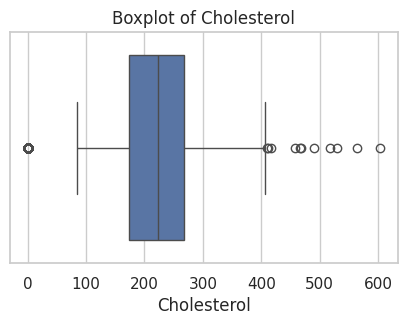

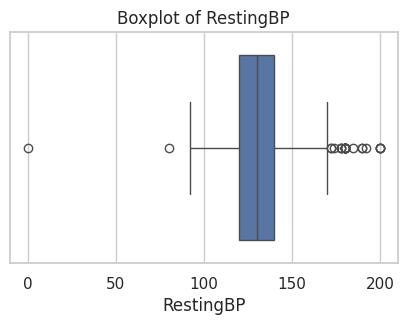

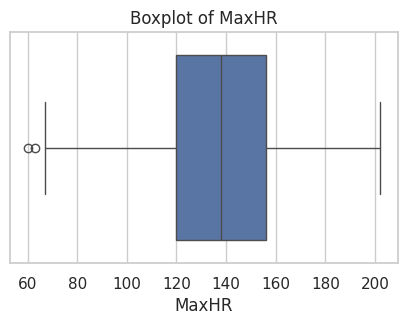

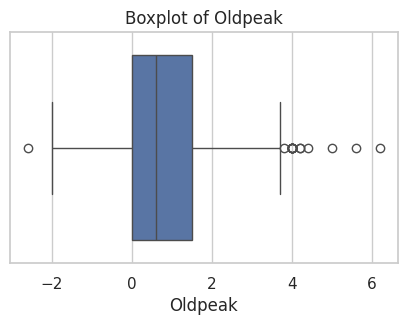

In [81]:
#Outlier check
import matplotlib.pyplot as plt
import seaborn as sns

for col in ['Cholesterol', 'RestingBP', 'MaxHR', 'Oldpeak']:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [82]:
# Function to detect outliers using the IQR method (exploration only, not for removal)
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    return outliers

# Example
outliers_chol = detect_outliers_iqr(df, 'Cholesterol')
print("Outliers in Cholesterol:", len(outliers_chol))

Outliers in Cholesterol: 183


In [83]:
# Clip 'Oldpeak' and 'Cholesterol' at the 99th percentile
for col in ['Oldpeak', 'Cholesterol']:
    upper = df[col].quantile(0.99)
    df[f"{col}_clipped"] = df[col].clip(upper=upper)

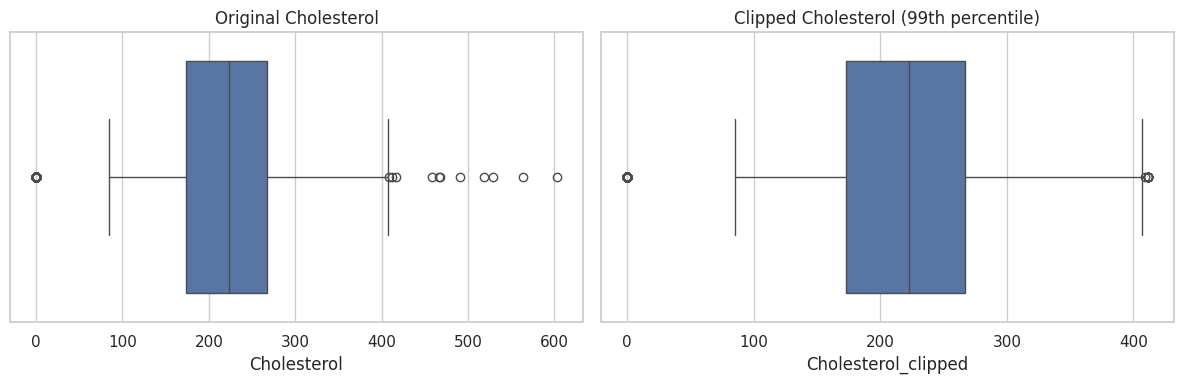

In [84]:
#Comparison plot original Cholesterol vs. clipped Cholesterol values
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.boxplot(x=df['Cholesterol'])
plt.title("Original Cholesterol")

plt.subplot(1, 2, 2)
sns.boxplot(x=df['Cholesterol_clipped'])
plt.title("Clipped Cholesterol (99th percentile)")

plt.tight_layout()
plt.show()

In [85]:
# Check duplicates
print(df.duplicated().any())
print(df.duplicated().sum())

False
0


In [86]:
# Check the shape
print(df.shape)

(918, 14)


In [87]:
#Print head
print(df.head())

   Age Sex ChestPainType  RestingBP  Cholesterol FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289         0     Normal    172   
1   49   F           NAP        160          180         0     Normal    156   
2   37   M           ATA        130          283         0         ST     98   
3   48   F           ASY        138          214         0     Normal    108   
4   54   M           NAP        150          195         0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  Oldpeak_clipped  \
0              N      0.0       Up             0              0.0   
1              N      1.0     Flat             1              1.0   
2              N      0.0       Up             0              0.0   
3              Y      1.5     Flat             1              1.5   
4              N      0.0       Up             0              0.0   

   Cholesterol_clipped  
0                289.0  
1                180.0  
2                283.0  
3   

In [88]:
# Set df to final encoded and preprocessed dataset
df = df_encoded.copy()

#Train-Test Split

In [89]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

In [90]:
# Define X and y
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Stratified train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Exploratory Data Analysis



In [91]:
# Set style for the plots
sns.set(style="whitegrid")

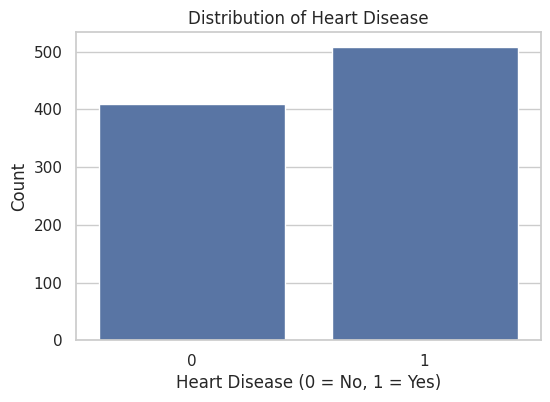

In [92]:
#Target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='HeartDisease')
plt.title("Distribution of Heart Disease")
plt.xlabel("Heart Disease (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

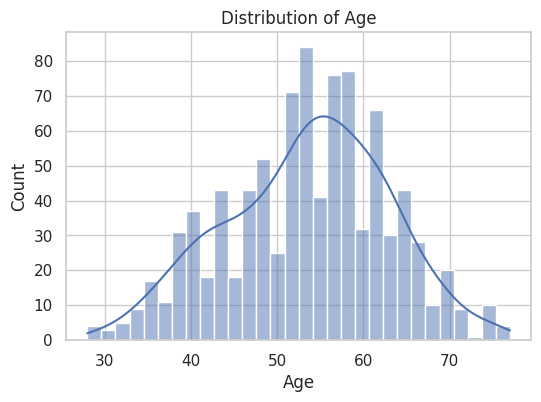

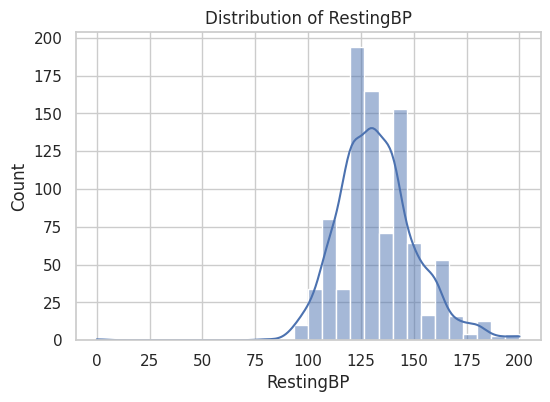

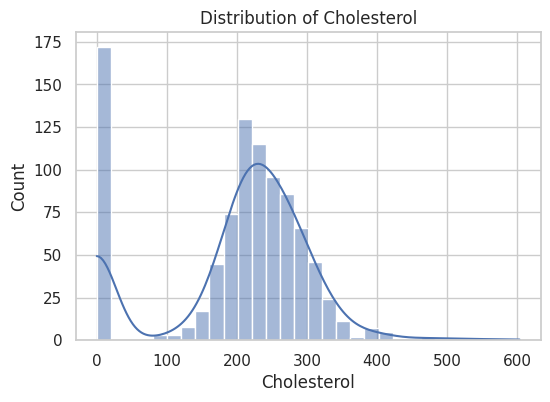

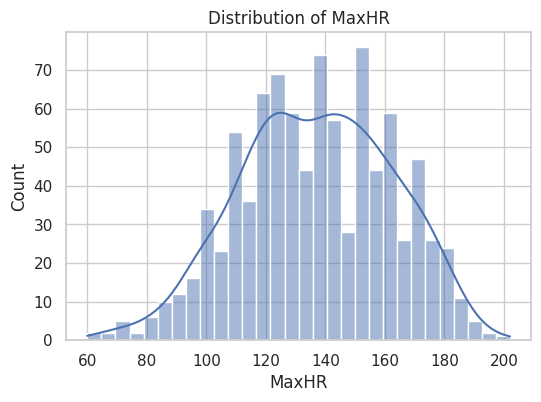

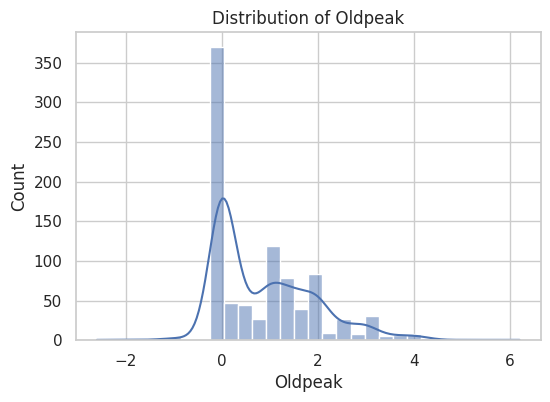

In [93]:
#Distribution plots for numeric features
numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

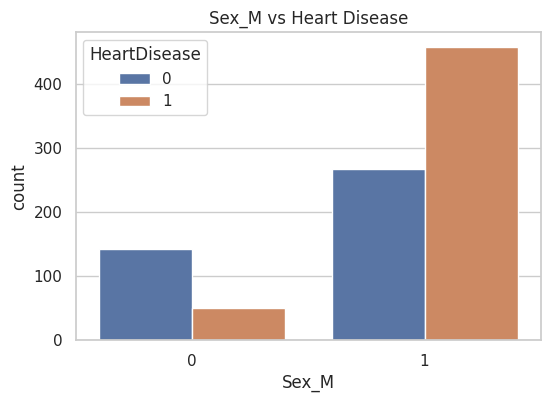

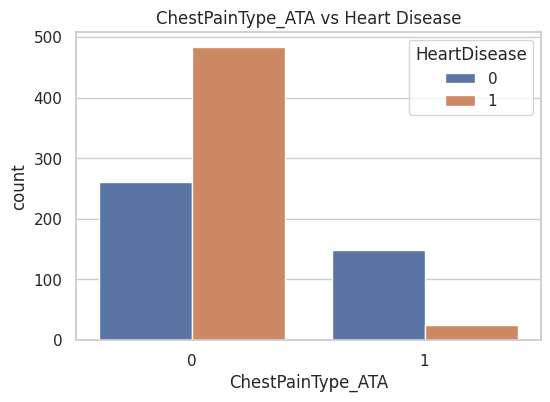

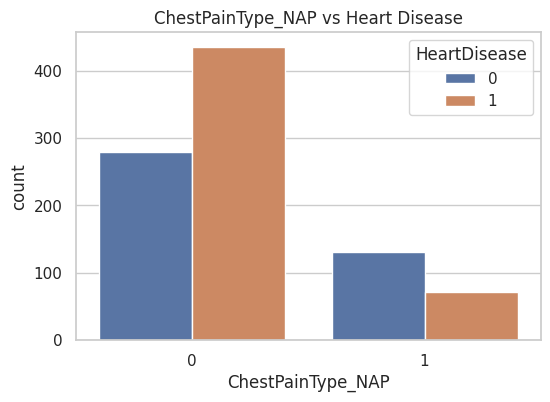

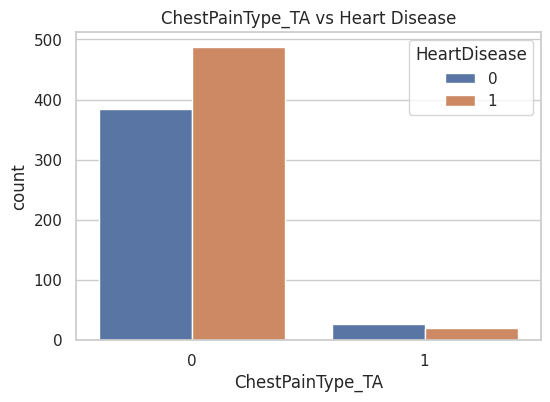

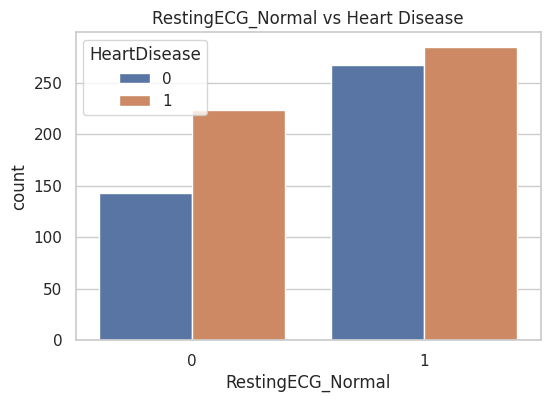

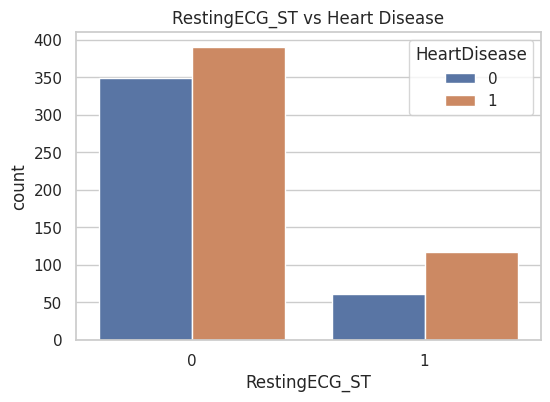

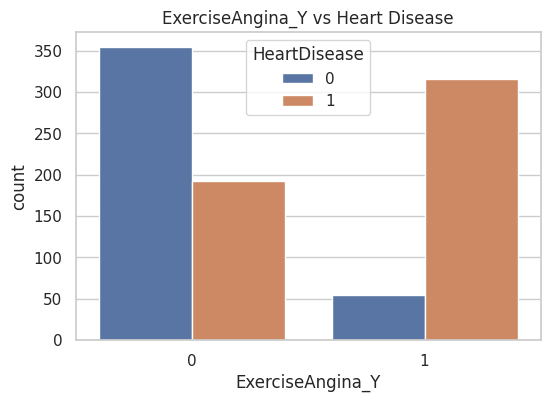

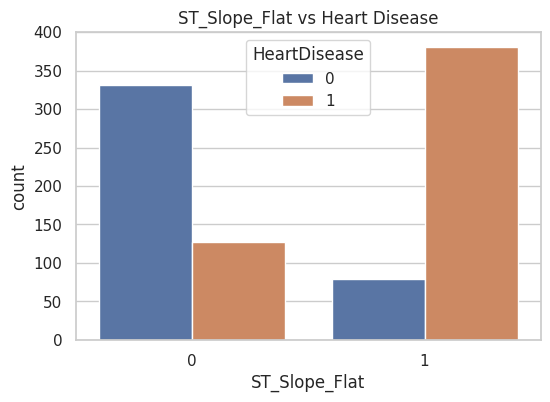

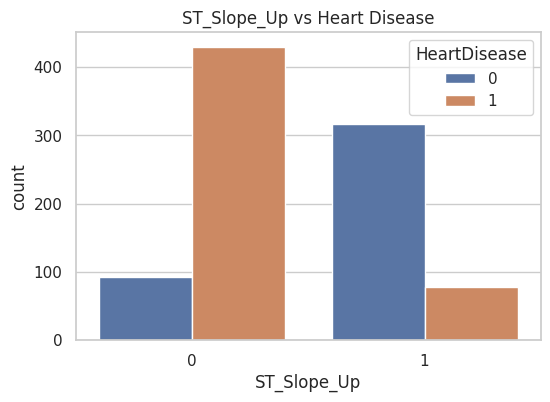

In [94]:
#Categorical feature counts
encoded_categorical_cols = [col for col in df.columns if col.startswith(('Sex_', 'ChestPainType_', 'RestingECG_', 'ExerciseAngina_', 'ST_Slope_'))]

for col in encoded_categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col, hue='HeartDisease')
    plt.title(f"{col} vs Heart Disease")
    plt.legend(title="HeartDisease")
    plt.show()

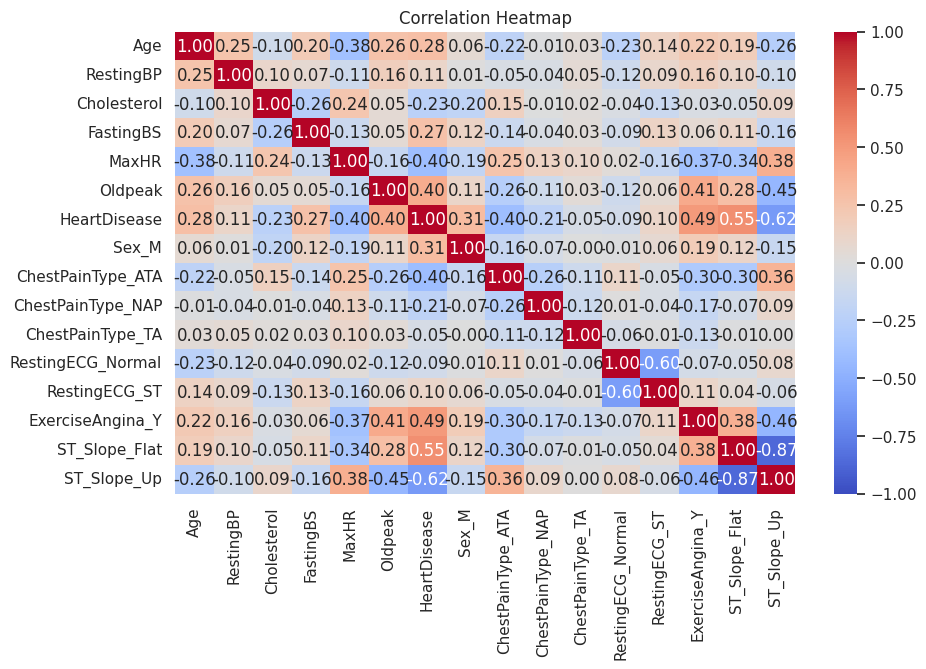

In [95]:
# Correlation heatmap centered at 0 to better highlight positive vs. negative relationships
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

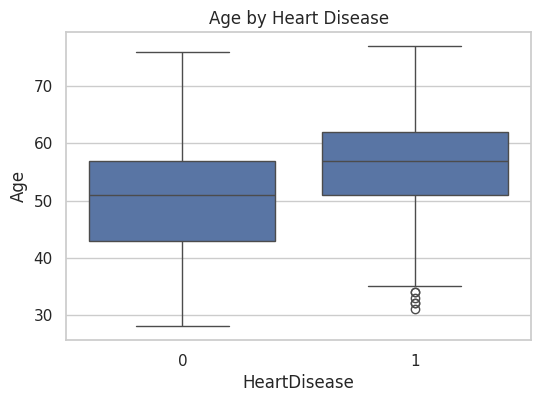

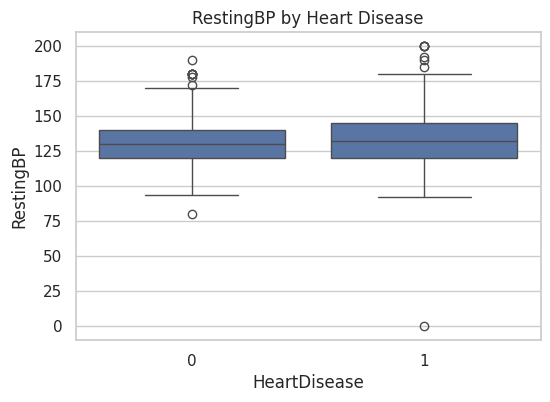

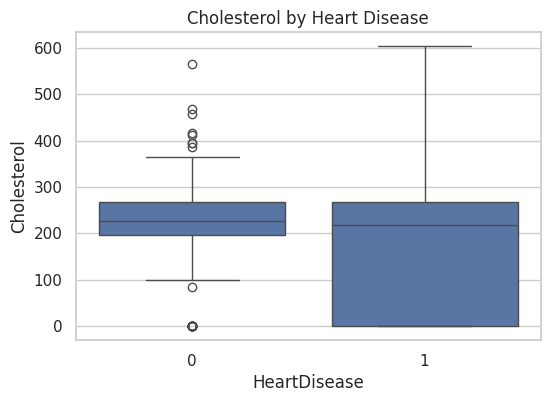

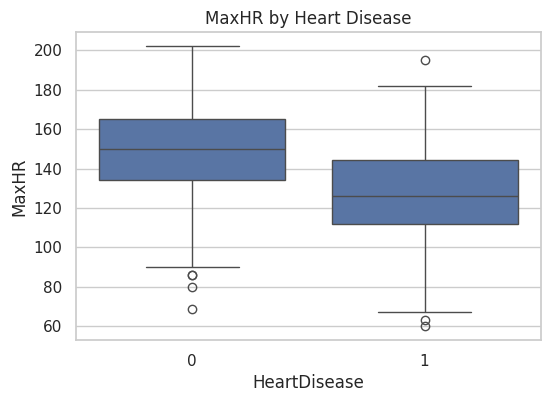

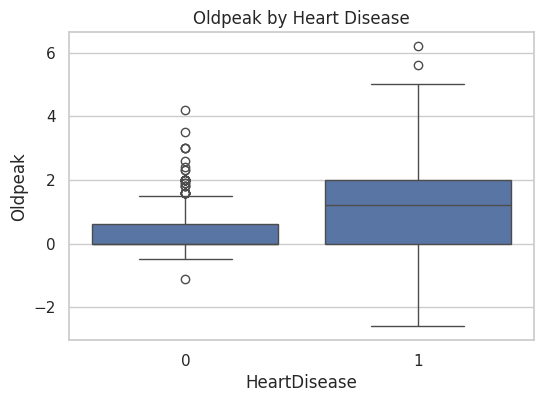

In [96]:
#Boxplots by HeartDisease
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='HeartDisease', y=col)
    plt.title(f"{col} by Heart Disease")
    plt.show()

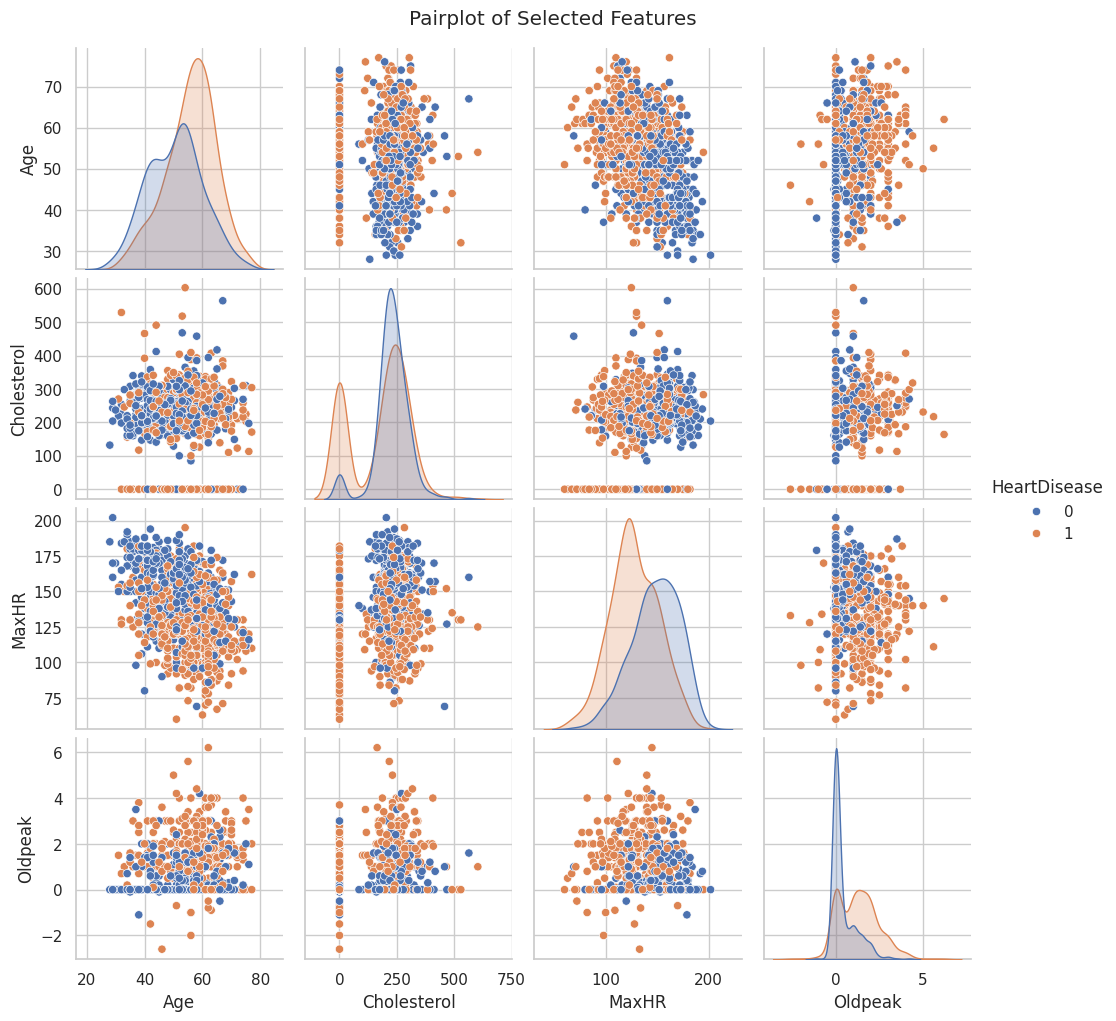

In [97]:
# Pairplot for selected numeric features + target
selected_cols = ['Age', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']
sns.pairplot(df[selected_cols], hue='HeartDisease')
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()

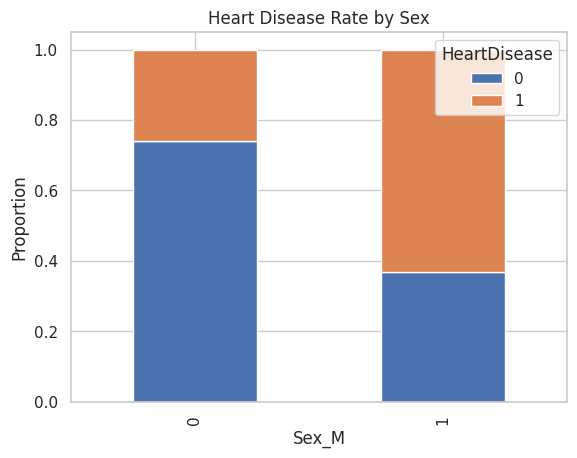

In [98]:
#Cross-tab for Sex vs HeartDisease
pd.crosstab(df['Sex_M'], df['HeartDisease'], normalize='index').plot(kind='bar', stacked=True)
plt.title("Heart Disease Rate by Sex")
plt.ylabel("Proportion")
plt.show()

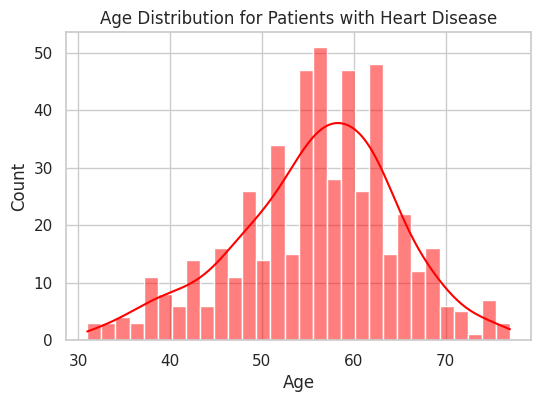

In [99]:
# Filter: Only rows with HeartDisease = 1
df_hd = df[df['HeartDisease'] == 1]

# Plot Age distribution
plt.figure(figsize=(6, 4))
sns.histplot(df_hd['Age'], bins=30, kde=True, color='red')
plt.title("Age Distribution for Patients with Heart Disease")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

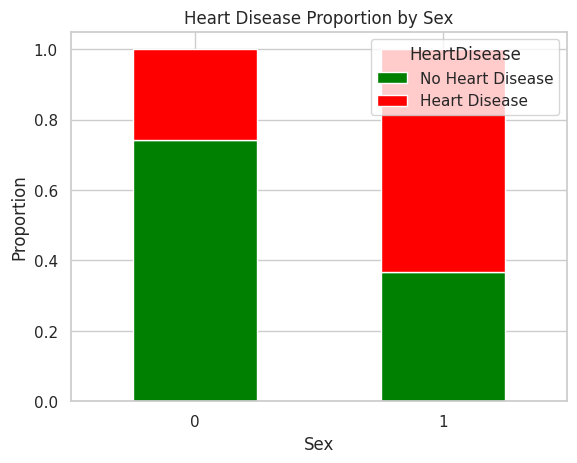

In [100]:
# Cross-tab and stacked bar chart
sex_hd = pd.crosstab(df['Sex_M'], df['HeartDisease'], normalize='index') #Corrected line to use 'Sex_M'

# Plot
sex_hd.plot(kind='bar', stacked=True, color=['green', 'red'])
plt.title("Heart Disease Proportion by Sex")
plt.ylabel("Proportion")
plt.xlabel("Sex")
plt.legend(["No Heart Disease", "Heart Disease"], title="HeartDisease")
plt.xticks(rotation=0)
plt.show()

#Feature engineering

##Scale features for Linear Model

In [101]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

Best C for L1 LogReg: 100


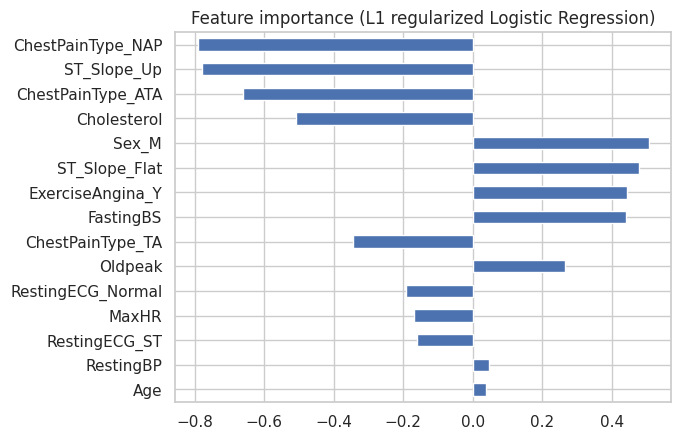

In [102]:
# L1 logreg pipeline
pipe_l1 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000))
])

# GridSearchCV for C
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100]
}

grid_l1 = GridSearchCV(pipe_l1, param_grid, cv=5, scoring='f1')
grid_l1.fit(X_train, y_train)

print("Best C for L1 LogReg:", grid_l1.best_params_['logreg__C'])

# Feature importance from best model
best_l1_model = grid_l1.best_estimator_
coef = best_l1_model.named_steps['logreg'].coef_[0]
importance_l1 = pd.Series(coef, index=X.columns)

# Plot only non-zero features
importance_l1[importance_l1 != 0].sort_values(key=abs).plot(kind='barh')
plt.title("Feature importance (L1 regularized Logistic Regression)")
plt.show()

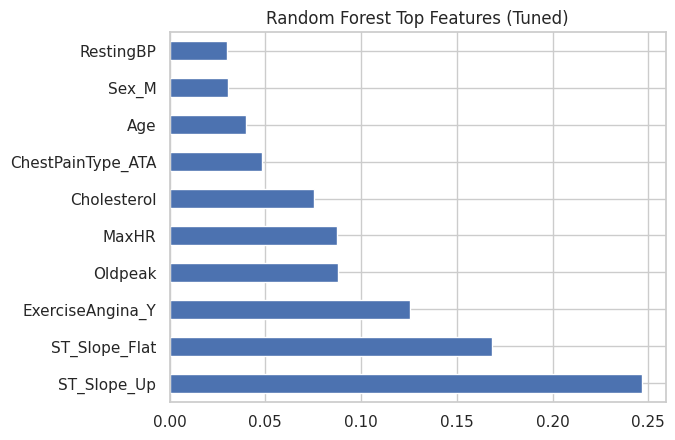

In [103]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest feature importance tuning
rf_importance = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)

# Model fit
rf_importance.fit(X_train, y_train)

# Feature importance calculation
importance_rf = pd.Series(rf_importance.feature_importances_, index=X.columns)

# Plot
importance_rf.sort_values(ascending=False).head(10).plot(kind='barh', title="Random Forest Top Features (Tuned)")
plt.show()


#Correlation Analysis

In [104]:
#(This is for feature engineering)
# Absolute correlation with target
corr = df.corr()['HeartDisease'].abs().sort_values(ascending=False)
print("Top correlated features:\n", corr.head(10))

Top correlated features:
 HeartDisease         1.000000
ST_Slope_Up          0.622164
ST_Slope_Flat        0.554134
ExerciseAngina_Y     0.494282
Oldpeak              0.403951
ChestPainType_ATA    0.401924
MaxHR                0.400421
Sex_M                0.305445
Age                  0.282039
FastingBS            0.267291
Name: HeartDisease, dtype: float64


##Dimension Reduction

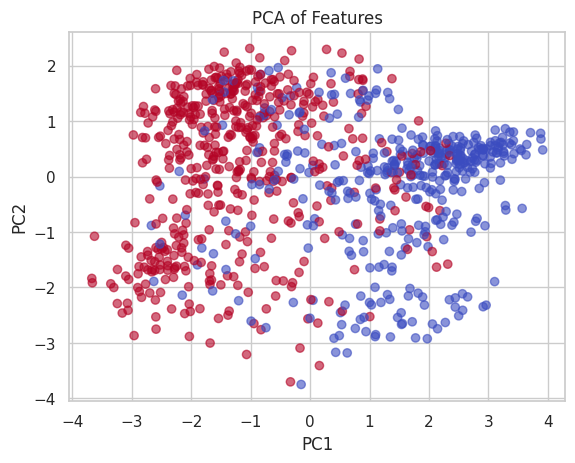

In [105]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA specifoed scaling
X_pca_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pca_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6)
plt.title("PCA of Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

#SMOTE - Synthetic Minority Oversampling Technique

In [106]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [107]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Original class distribution:")
print(y_train.value_counts())

print("\nSMOTE-resampled class distribution:")
print(pd.Series(y_train_smote).value_counts())

Original class distribution:
HeartDisease
1    406
0    328
Name: count, dtype: int64

SMOTE-resampled class distribution:
HeartDisease
1    406
0    406
Name: count, dtype: int64


#Model Evaluation Function

In [108]:
def evaluate_model(y_true, y_pred, y_prob, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    print(f"\n{model_name} Evaluation:")
    print(classification_report(y_true, y_pred))
    print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1-score: {f1:.3f} | ROC AUC: {auc:.3f}")

    # Confusion matrix
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return metrics as dict
    return {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'ROC AUC': auc
    }

#Models

##Baseline and ML cLassifier

In [109]:
# Most frequent class
baseline_pred = [y_train.mode()[0]] * len(y_test)

from sklearn.metrics import accuracy_score
baseline_acc = accuracy_score(y_test, baseline_pred)
print("Baseline Accuracy (majority class):", round(baseline_acc, 3))

Baseline Accuracy (majority class): 0.554


###Evaluation Metrics


Baseline (Majority Class) Evaluation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.55      1.00      0.71       102

    accuracy                           0.55       184
   macro avg       0.28      0.50      0.36       184
weighted avg       0.31      0.55      0.40       184

Accuracy: 0.554 | Precision: 0.554 | Recall: 1.000 | F1-score: 0.713 | ROC AUC: 0.500


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


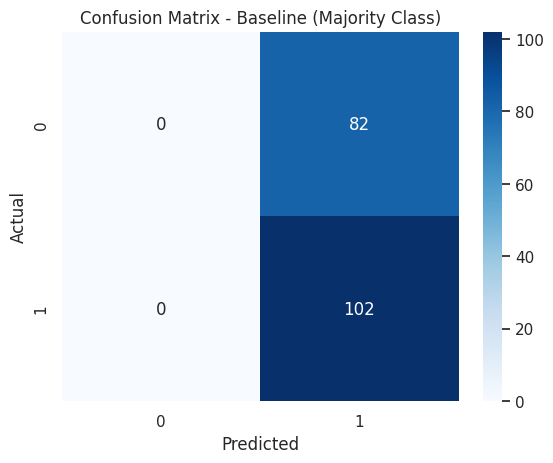

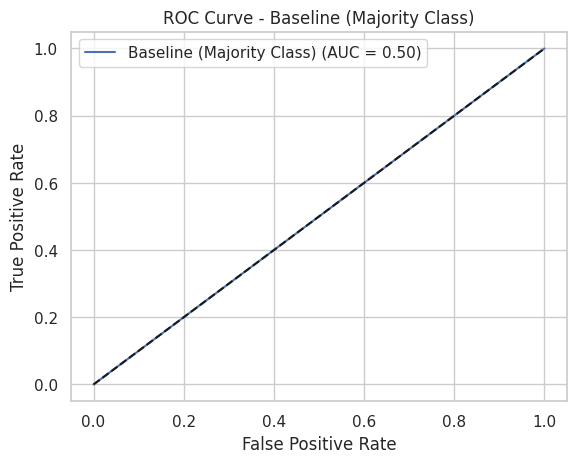

In [110]:
# Baseline model: always predict the majority class from y_train
from sklearn.metrics import accuracy_score

baseline_class = y_train.mode()[0]
baseline_pred = [baseline_class] * len(y_test)
baseline_prob = [baseline_class] * len(y_test)

# Evaluate baseline using the same function as other models
baseline_metrics = evaluate_model(y_test, baseline_pred, baseline_prob, "Baseline (Majority Class)")

##Logistic Regression Models

###Default Logistic Regression

In [111]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Make the Pipeline
pipe_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])

# Regularization value (C) tuning with GridSearch
param_grid_logreg = {
    'logreg__C': [0.01, 0.1, 1, 10, 100]
}

# GridSearchCV
grid_logreg = GridSearchCV(pipe_logreg, param_grid_logreg, cv=5, scoring='f1')
grid_logreg.fit(X_train, y_train)

# Best model
# Best model
best_logreg = grid_logreg.best_estimator_
print("Best C for Logistic Regression (L2):", grid_logreg.best_params_['logreg__C'])

Best C for Logistic Regression (L2): 0.01


###Logistic Regression with class_weight

In [112]:
# Model with class_weight='balanced' to address class imbalance
logreg_balanced = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg_balanced.fit(X_train, y_train)

# NOTE: No prediction or evaluation here yet!
# Final evaluation on the test set will be performed later after model selection.

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000)

###Logistic Regression with SMOTE

In [113]:
# Model with SMOTE
logreg_smote = LogisticRegression(max_iter=1000)
logreg_smote.fit(X_train_smote, y_train_smote)

# NOTE: No prediction or evaluation here yet!
# Final evaluation on the test set will be performed later after model selection.

LogisticRegression(max_iter=1000)

####Cross-Validation on Logistic Regression

In [114]:
# Cross-validation on Logistic Regression
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression  # Import LogisticRegression if not already done

# Initialize LogisticRegression
logreg = LogisticRegression(max_iter=1000) # Initialize a LogisticRegression model

# Or, assign to one of the existing models:
# logreg = logreg_balanced  # If you want to cross-validate the balanced model
# logreg = logreg_smote     # If you want to cross-validate the SMOTE model

cv_logreg = cross_validate(logreg, X, y, cv=5,
                           scoring=['accuracy', 'f1', 'roc_auc'],
                           return_train_score=False)

print("Logistic Regression CV scores:")
print("Accuracy:", round(cv_logreg['test_accuracy'].mean(), 3))
print("F1 Score:", round(cv_logreg['test_f1'].mean(), 3))
print("ROC AUC:", round(cv_logreg['test_roc_auc'].mean(), 3))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Logistic Regression CV scores:
Accuracy: 0.832
F1 Score: 0.846
ROC AUC: 0.908


##Random Forest Models

###Default Random Forest Model

In [115]:
# Default Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# NOTE: No prediction or evaluation here yet!
# Final evaluation on the test set will be performed later after model selection.

RandomForestClassifier(max_depth=5, random_state=42)

###Random Forest with class_weight

In [116]:
# Random Forest with class_weight='balanced' to address class imbalance
rf_balanced = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=42)
rf_balanced.fit(X_train, y_train)

# NOTE: No prediction or evaluation here yet!
# Final evaluation on the test set will be performed later after model selection.

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

###Random Forest with SMOTE

In [117]:
# Fit a model on SMOTE-resampled data
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)

# NOTE: No prediction or evaluation here yet!
# Final evaluation on the test set will be performed later after model selection.

RandomForestClassifier(random_state=42)

####Cross-validation on Random Forest

In [118]:
# Cross-validation on Random Forest
cv_rf = cross_validate(rf, X, y, cv=5,
                       scoring=['accuracy', 'f1', 'roc_auc'],
                       return_train_score=False)

print("Random Forest CV scores:")
print("Accuracy:", round(cv_rf['test_accuracy'].mean(), 3))
print("F1 Score:", round(cv_rf['test_f1'].mean(), 3))
print("ROC AUC:", round(cv_rf['test_roc_auc'].mean(), 3))

Random Forest CV scores:
Accuracy: 0.821
F1 Score: 0.838
ROC AUC: 0.91


###Random Forest with Hyperparameter Tuning

In [119]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter optimization for Random Forest
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Best parameters:", grid_rf.best_params_)
print("Best CV F1-score:", grid_rf.best_score_)

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 150}
Best CV F1-score: 0.8848733217059813


In [120]:
# Best model
best_rf = grid_rf.best_estimator_
print("Best parameters:", grid_rf.best_params_)
print("Best CV F1-score:", grid_rf.best_score_)

# NOTE: No prediction or evaluation here yet!
# Final evaluation on the test set will be performed later after model selection.

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 150}
Best CV F1-score: 0.8848733217059813


In [121]:
# Hyperparameter optimization for Random Forest (SMOTE-resampled data)

param_grid_rf_smote = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5]
}

grid_rf_smote = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf_smote,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_rf_smote.fit(X_train_smote, y_train_smote)

# Save the best model
best_rf_smote = grid_rf_smote.best_estimator_

print("Best parameters for SMOTE RF:", grid_rf_smote.best_params_)
print("Best CV F1-score for SMOTE RF:", grid_rf_smote.best_score_)

# NOTE: No prediction or evaluation here yet!
# Final evaluation on the test set will be performed later after model selection.

Best parameters for SMOTE RF: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 150}
Best CV F1-score for SMOTE RF: 0.8752402765717994


##Deep Learning Model

In [122]:
# Deep Learning scaling
from sklearn.preprocessing import StandardScaler

scaler_dl = StandardScaler()
X_train_dl = scaler_dl.fit_transform(X_train)
X_test_dl = scaler_dl.transform(X_test)

X_train_dl = X_train_dl.astype('float32')
X_test_dl = X_test_dl.astype('float32')

In [123]:
# Import
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Deep Learning model for Heart Disease Prediction
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit model
history = model.fit(
    X_train_dl, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6073 - auc: 0.6965 - loss: 0.6782 - val_accuracy: 0.7551 - val_auc: 0.8069 - val_loss: 0.5774
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7523 - auc: 0.8311 - loss: 0.5378 - val_accuracy: 0.8095 - val_auc: 0.8374 - val_loss: 0.4940
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8375 - auc: 0.9168 - loss: 0.4059 - val_accuracy: 0.8231 - val_auc: 0.8450 - val_loss: 0.4647
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8434 - auc: 0.9344 - loss: 0.3472 - val_accuracy: 0.8299 - val_auc: 0.8505 - val_loss: 0.4591
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8632 - auc: 0.9312 - loss: 0.3455 - val_accuracy: 0.8299 - val_auc: 0.8529 - val_loss: 0.4595
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8442 - auc: 0.9275 - loss: 0.3415 - val_accuracy: 0.8299 - val_auc: 0.8580 - val_loss: 0.4609
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - ac

###Prediction and Evaluation

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Deep Learning (MLP) Evaluation:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        82
           1       0.87      0.90      0.88       102

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184

Accuracy: 0.870 | Precision: 0.868 | Recall: 0.902 | F1-score: 0.885 | ROC AUC: 0.932


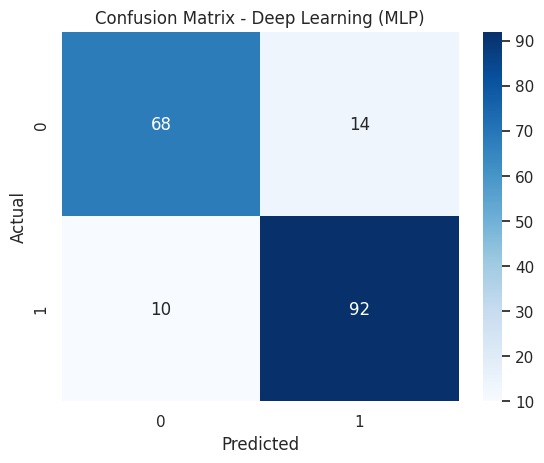

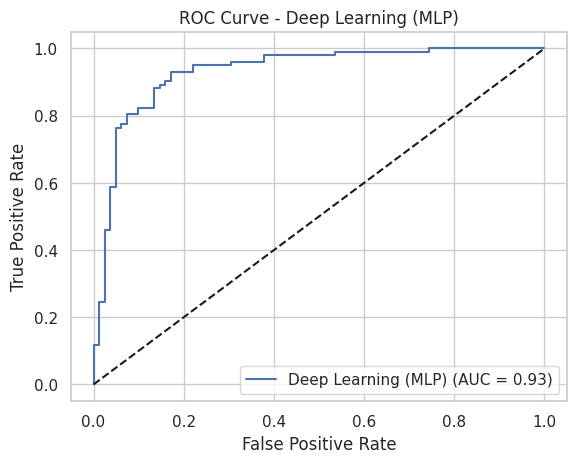

In [124]:
# Predict
y_prob_dl = model.predict(X_test_dl).flatten()
y_pred_dl = (y_prob_dl >= 0.5).astype(int)

# Evaluate
metrics_dl = evaluate_model(y_test, y_pred_dl, y_prob_dl, "Deep Learning (MLP)")

###Learning curves

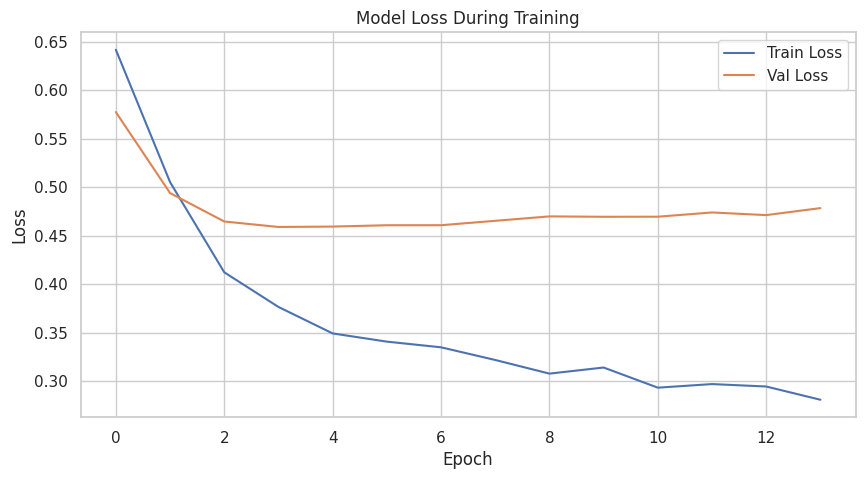

In [125]:
# Learning curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

##Compare Train and Test Performance

In [126]:
def compare_train_test(model, X_train, y_train, X_test, y_test, model_name, is_keras=False):
    if is_keras:
        y_train_prob = model.predict(X_train).flatten()
        y_test_prob = model.predict(X_test).flatten()
    else:
        y_train_prob = model.predict_proba(X_train)[:, 1]
        y_test_prob = model.predict_proba(X_test)[:, 1]

    y_train_pred = (y_train_prob >= 0.5).astype(int)
    y_test_pred = (y_test_prob >= 0.5).astype(int)

    def get_metrics(y_true, y_pred, y_prob):
        return {
            "Accuracy": accuracy_score(y_true, y_pred),
            "Precision": precision_score(y_true, y_pred),
            "Recall": recall_score(y_true, y_pred),
            "F1 Score": f1_score(y_true, y_pred),
            "ROC AUC": roc_auc_score(y_true, y_prob)
        }

    train_metrics = get_metrics(y_train, y_train_pred, y_train_prob)
    test_metrics = get_metrics(y_test, y_test_pred, y_test_prob)

    comparison = {
        "Model": model_name,
        "Train Accuracy": train_metrics["Accuracy"],
        "Test Accuracy": test_metrics["Accuracy"],
        "Train F1 Score": train_metrics["F1 Score"],
        "Test F1 Score": test_metrics["F1 Score"],
        "Train ROC AUC": train_metrics["ROC AUC"],
        "Test ROC AUC": test_metrics["ROC AUC"]
    }

    return comparison

### Comparison for all models

In [127]:
# === Train vs Test performance comparison for all models ===
comparison_results = []

# Logistic Regression (Tuned L2)
comparison_results.append(compare_train_test(best_logreg, X_train, y_train, X_test, y_test, "Logistic Regression (Tuned)"))

# Logistic Regression (Balanced)
comparison_results.append(compare_train_test(logreg_balanced, X_train, y_train, X_test, y_test, "Logistic Regression (Balanced)"))

# Logistic Regression (SMOTE)
comparison_results.append(compare_train_test(logreg_smote, X_train, y_train, X_test, y_test, "Logistic Regression (SMOTE)"))

# Random Forest (Default)
comparison_results.append(compare_train_test(rf, X_train, y_train, X_test, y_test, "Random Forest (Default)"))

# Random Forest (Balanced)
comparison_results.append(compare_train_test(rf_balanced, X_train, y_train, X_test, y_test, "Random Forest (Balanced)"))

# Random Forest (Tuned)
comparison_results.append(compare_train_test(best_rf, X_train, y_train, X_test, y_test, "Random Forest (Tuned)"))

# Random Forest (Tuned on SMOTE)
comparison_results.append(compare_train_test(best_rf_smote, X_train, y_train, X_test, y_test, "Random Forest (SMOTE Tuned)"))

# Deep Learning (MLP)
comparison_results.append(compare_train_test(model, X_train_dl, y_train, X_test_dl, y_test, "Deep Learning (MLP)", is_keras=True))

# Create DataFrame
comparison_df = pd.DataFrame(comparison_results)

# Display results
display(comparison_df.round(3))

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


,Model,Train Accuracy,Test Accuracy,Train F1 Score,Test F1 Score,Train ROC AUC,Test ROC AUC
0,Logistic Regression (Tuned),0.864,0.880,0.880,0.894,0.929,0.935
1,Logistic Regression (Balanced),0.857,0.891,0.871,0.905,0.933,0.930
2,Logistic Regression (SMOTE),0.861,0.902,0.874,0.913,0.929,0.936
3,Random Forest (Default),0.887,0.859,0.901,0.877,0.961,0.932
4,Random Forest (Balanced),0.890,0.864,0.903,0.880,0.962,0.928
5,Random Forest (Tuned),0.958,0.880,0.962,0.892,0.995,0.933
6,Random Forest (SMOTE Tuned),1.000,0.880,1.000,0.892,1.000,0.938
7,Deep Learning (MLP),0.861,0.870,0.879,0.885,0.925,0.932


##Final Model Comparison

In [128]:
# Define a dictionary of model predictions and probabilities

# Make predictions for Logistic Regression models
y_pred_logreg = best_logreg.predict(X_test)  # Predictions for tuned L2 LogReg
y_prob_logreg = best_logreg.predict_proba(X_test)[:, 1]  # Probabilities for tuned L2 LogReg

y_pred_logreg_bal = logreg_balanced.predict(X_test)  # Predictions for balanced LogReg
y_prob_logreg_bal = logreg_balanced.predict_proba(X_test)[:, 1]  # Probabilities for balanced LogReg

y_pred_logreg_smote = logreg_smote.predict(X_test)  # Predictions for SMOTE LogReg
y_prob_logreg_smote = logreg_smote.predict_proba(X_test)[:, 1]  # Probabilities for SMOTE LogReg

# Make predictions for Random Forest models
y_pred_rf = rf.predict(X_test)  # Predictions for default RF
y_prob_rf = rf.predict_proba(X_test)[:, 1]  # Probabilities for default RF

y_pred_rf_bal = rf_balanced.predict(X_test)  # Predictions for balanced RF
y_prob_rf_bal = rf_balanced.predict_proba(X_test)[:, 1]  # Probabilities for balanced RF

y_pred_rf_smote = rf_smote.predict(X_test)  # Predictions for SMOTE RF
y_prob_rf_smote = rf_smote.predict_proba(X_test)[:, 1]  # Probabilities for SMOTE RF

y_pred_best_rf = best_rf.predict(X_test)  # Predictions for tuned RF
y_prob_best_rf = best_rf.predict_proba(X_test)[:, 1]  # Probabilities for tuned RF


LogReg Evaluation:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        82
           1       0.88      0.91      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184

Accuracy: 0.880 | Precision: 0.877 | Recall: 0.912 | F1-score: 0.894 | ROC AUC: 0.935


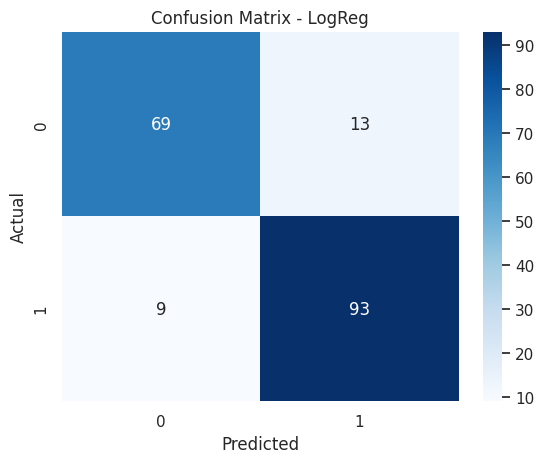

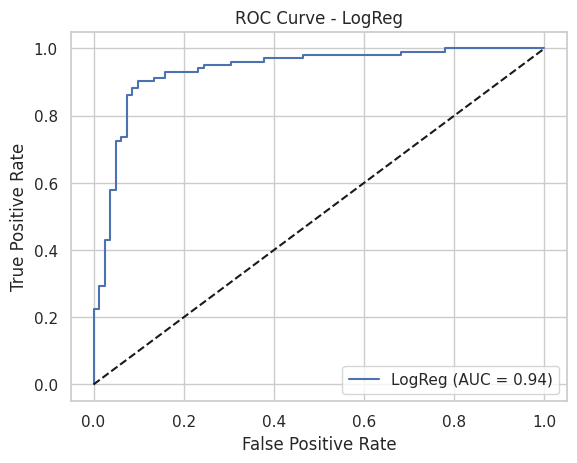


LogReg Balanced Evaluation:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87        82
           1       0.88      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184

Accuracy: 0.891 | Precision: 0.880 | Recall: 0.931 | F1-score: 0.905 | ROC AUC: 0.930


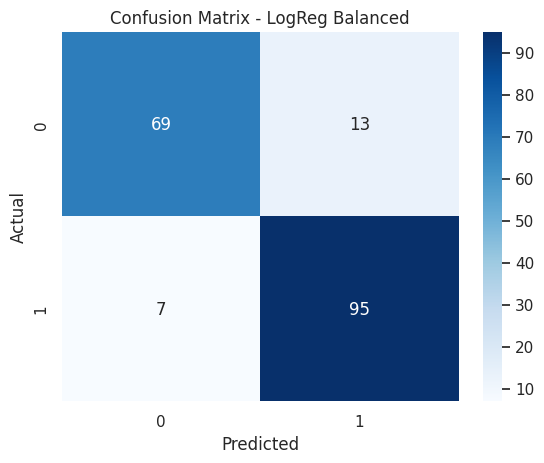

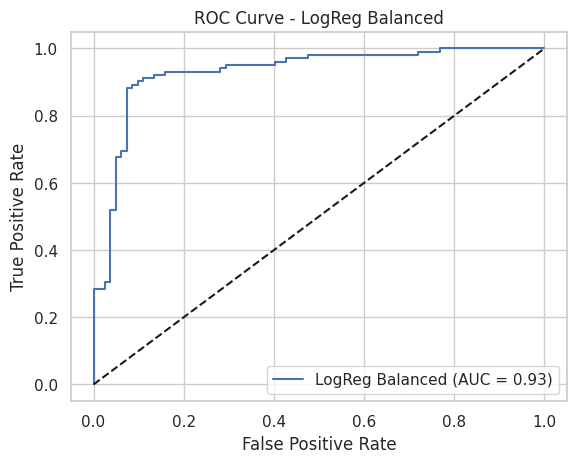


LogReg SMOTE Evaluation:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        82
           1       0.90      0.93      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

Accuracy: 0.902 | Precision: 0.896 | Recall: 0.931 | F1-score: 0.913 | ROC AUC: 0.936


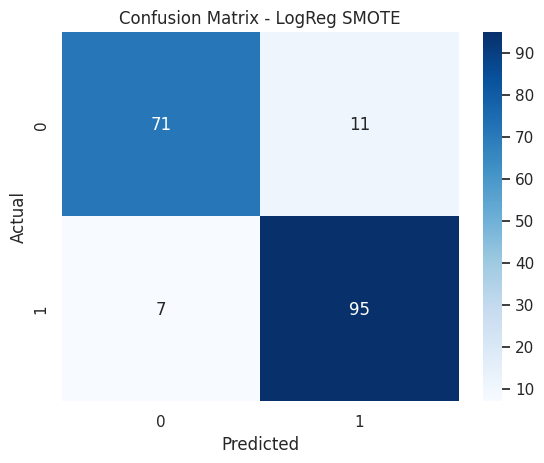

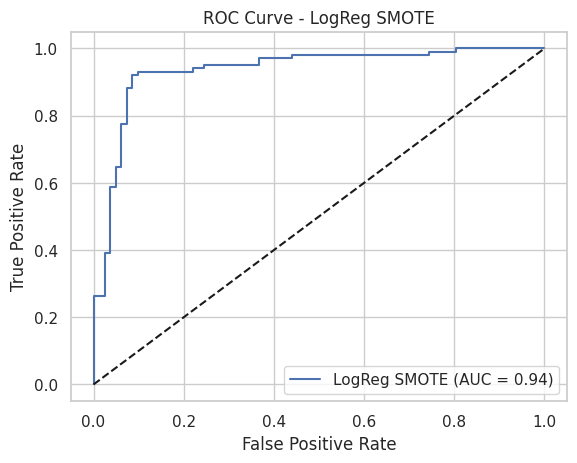


RF Evaluation:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        82
           1       0.85      0.91      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.86       184
weighted avg       0.86      0.86      0.86       184

Accuracy: 0.859 | Precision: 0.845 | Recall: 0.912 | F1-score: 0.877 | ROC AUC: 0.932


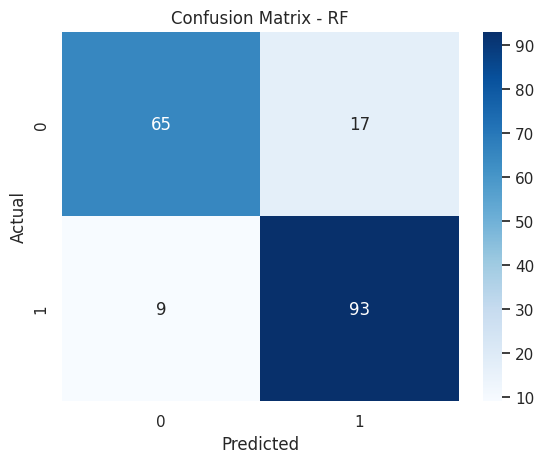

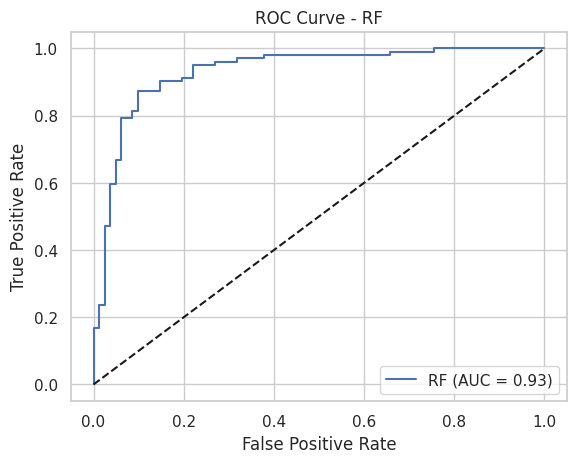


RF Balanced Evaluation:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84        82
           1       0.86      0.90      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

Accuracy: 0.864 | Precision: 0.860 | Recall: 0.902 | F1-score: 0.880 | ROC AUC: 0.928


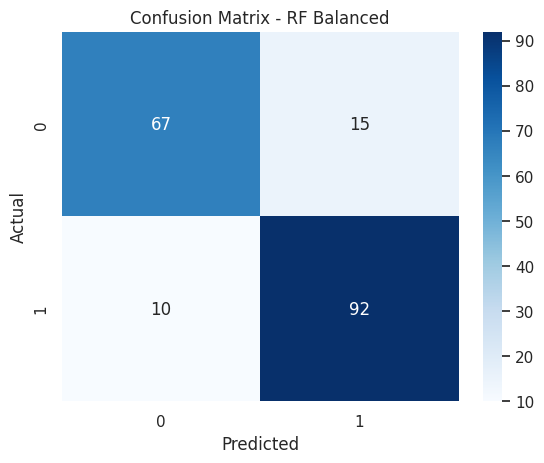

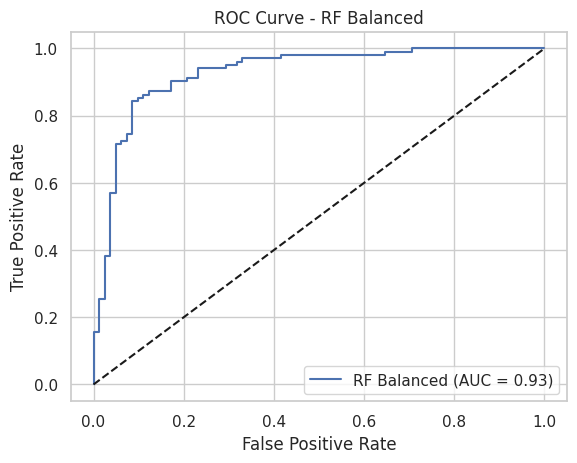


RF SMOTE Evaluation:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        82
           1       0.89      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184

Accuracy: 0.880 | Precision: 0.892 | Recall: 0.892 | F1-score: 0.892 | ROC AUC: 0.940


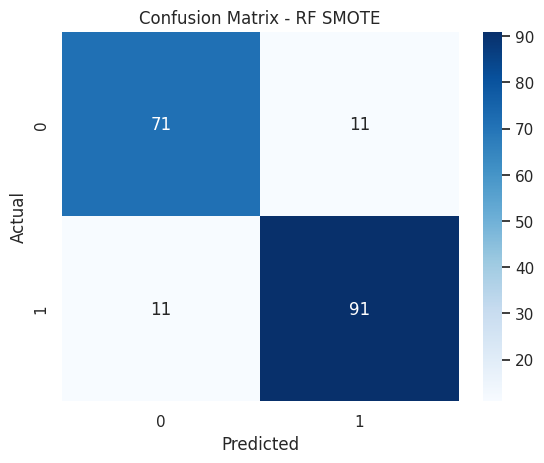

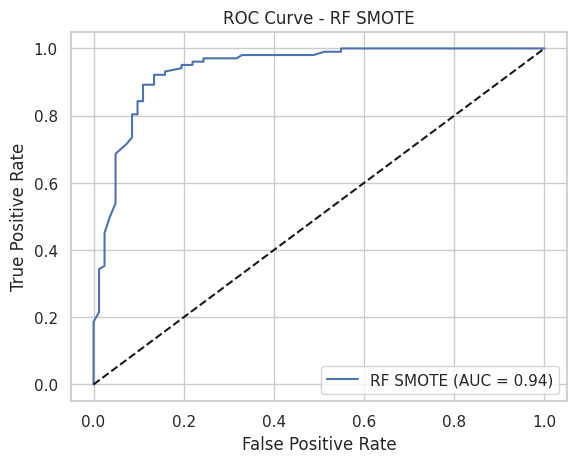


RF Tuned Evaluation:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        82
           1       0.89      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184

Accuracy: 0.880 | Precision: 0.892 | Recall: 0.892 | F1-score: 0.892 | ROC AUC: 0.933


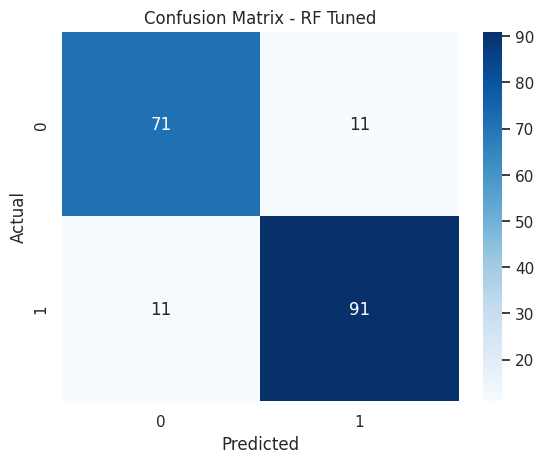

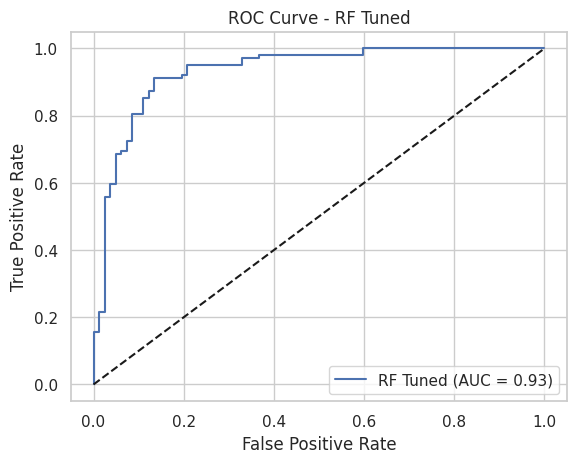


Deep Learning (MLP) Evaluation:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        82
           1       0.87      0.90      0.88       102

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184

Accuracy: 0.870 | Precision: 0.868 | Recall: 0.902 | F1-score: 0.885 | ROC AUC: 0.932


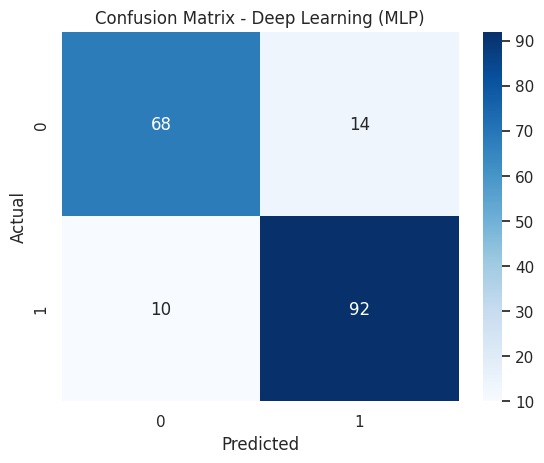

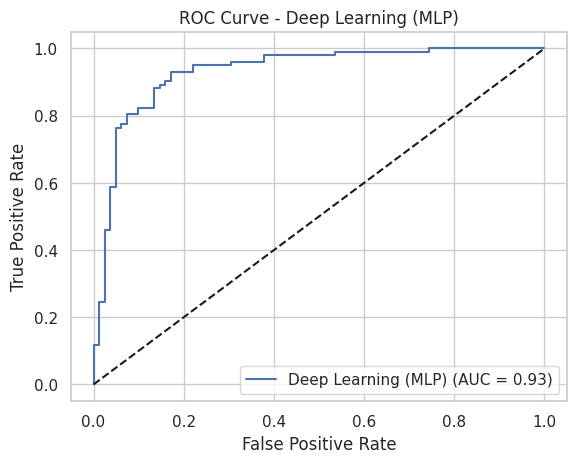

,Model,Accuracy,Precision,Recall,F1-score,ROC AUC
2,LogReg SMOTE,0.902174,0.896226,0.931373,0.913462,0.935677
1,LogReg Balanced,0.891304,0.879630,0.931373,0.904762,0.930416
0,LogReg,0.880435,0.877358,0.911765,0.894231,0.935079
5,RF SMOTE,0.880435,0.892157,0.892157,0.892157,0.939802
6,RF Tuned,0.880435,0.892157,0.892157,0.892157,0.932927
7,Deep Learning (MLP),0.869565,0.867925,0.901961,0.884615,0.932090
4,RF Balanced,0.864130,0.859813,0.901961,0.880383,0.927666
3,RF,0.858696,0.845455,0.911765,0.877358,0.932090


In [129]:
# Define a dictionary of model predictions and probabilities
models = {
    "LogReg": (y_pred_logreg, y_prob_logreg),
    "LogReg Balanced": (y_pred_logreg_bal, y_prob_logreg_bal),
    "LogReg SMOTE": (y_pred_logreg_smote, y_prob_logreg_smote),
    "RF": (y_pred_rf, y_prob_rf),
    "RF Balanced": (y_pred_rf_bal, y_prob_rf_bal),
    "RF SMOTE": (y_pred_rf_smote, y_prob_rf_smote),
    "RF Tuned": (y_pred_best_rf, y_prob_best_rf),
    "Deep Learning (MLP)": (y_pred_dl, y_prob_dl)
}

# Evaluate all models in a for-loop
results = []
for model_name, (y_pred, y_prob) in models.items():
    result = evaluate_model(y_test, y_pred, y_prob, model_name)
    results.append(result)

# Create the results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1-score", ascending=False)
display(results_df)

In [130]:
import pandas as pd
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1-score", ascending=False)
display(results_df)

,Model,Accuracy,Precision,Recall,F1-score,ROC AUC
2,LogReg SMOTE,0.902174,0.896226,0.931373,0.913462,0.935677
1,LogReg Balanced,0.891304,0.879630,0.931373,0.904762,0.930416
0,LogReg,0.880435,0.877358,0.911765,0.894231,0.935079
5,RF SMOTE,0.880435,0.892157,0.892157,0.892157,0.939802
6,RF Tuned,0.880435,0.892157,0.892157,0.892157,0.932927
7,Deep Learning (MLP),0.869565,0.867925,0.901961,0.884615,0.932090
4,RF Balanced,0.864130,0.859813,0.901961,0.880383,0.927666
3,RF,0.858696,0.845455,0.911765,0.877358,0.932090


In [131]:
# Export results table to CSV (optional for report)
results_df.to_csv("model_comparison_results.csv", index=False)

##Cross Validation

In [132]:
# Create and fit the scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale the features in X
cv_scores_rf = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
cv_scores_logreg = cross_val_score(logreg, X_scaled, y, cv=5, scoring='roc_auc')

print("Random Forest CV ROC-AUC:", round(cv_scores_rf.mean(), 3))
print("Logistic Regression CV ROC-AUC:", round(cv_scores_logreg.mean(), 3))

Random Forest CV ROC-AUC: 0.91
Logistic Regression CV ROC-AUC: 0.908


##Choosing the best model

In [133]:
#Choosing best model based on F1 score
best_model_name = results_df.iloc[0]['Model']
print(f"Thebest model based on F1 score: {best_model_name}")

# Calculate the difference between training and test F1 scores (a large gap may indicate overfitting)
comparison_df["F1 Gap"] = comparison_df["Train F1 Score"] - comparison_df["Test F1 Score"]

# Select the best model based on:
# 1. High test F1 score (good generalization performance)
# 2. Low train-test F1 gap (minimal overfitting)
best_model_row = comparison_df.sort_values(by=["Test F1 Score", "F1 Gap"], ascending=[False, True]).iloc[0]
best_model_name = best_model_row["Model"]

print("Best model based on F1 and generalization gap:", best_model_name)

Thebest model based on F1 score: LogReg SMOTE
Best model based on F1 and generalization gap: Logistic Regression (SMOTE)


##Saving the best model

In [134]:
import joblib

# Dictionary for my models
model_dict = {
    "Logistic Regression (Tuned)": best_logreg,
    "Logistic Regression (Balanced)": logreg_balanced,
    "Logistic Regression (SMOTE)": logreg_smote,
    "Random Forest (Default)": rf,
    "Random Forest (Balanced)": rf_balanced,
    "Random Forest (Tuned)": best_rf,
    "Random Forest (SMOTE Tuned)": best_rf_smote,
    "Deep Learning (MLP)": model
}

# Saving my model
# Save the best model
best_model = model_dict[best_model_name]

if best_model_name == "Deep Learning (MLP)":
    best_model.save("best_model_dl.h5")
else:
    joblib.dump(best_model, "best_model.pkl")

# Final evaluation on test set - after model selection


--- FINAL TEST SET EVALUATION ---


Logistic Regression (Tuned L2) Evaluation:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        82
           1       0.88      0.91      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184

Accuracy: 0.880 | Precision: 0.877 | Recall: 0.912 | F1-score: 0.894 | ROC AUC: 0.935


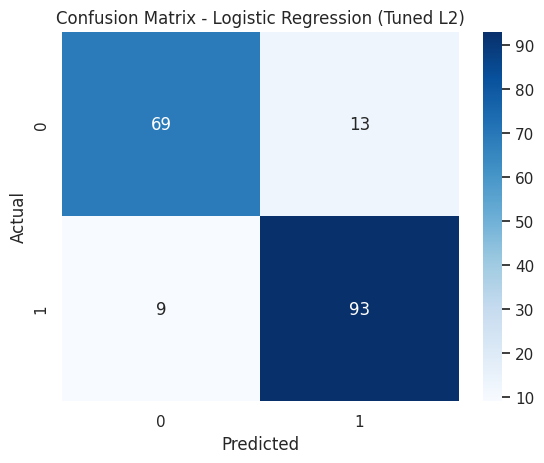

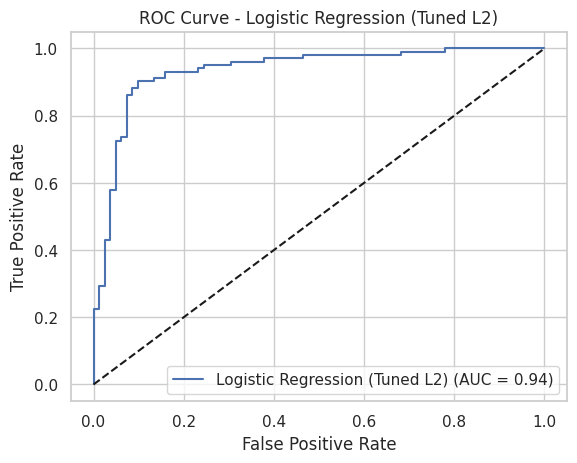


Logistic Regression (Balanced) Evaluation:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87        82
           1       0.88      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184

Accuracy: 0.891 | Precision: 0.880 | Recall: 0.931 | F1-score: 0.905 | ROC AUC: 0.930


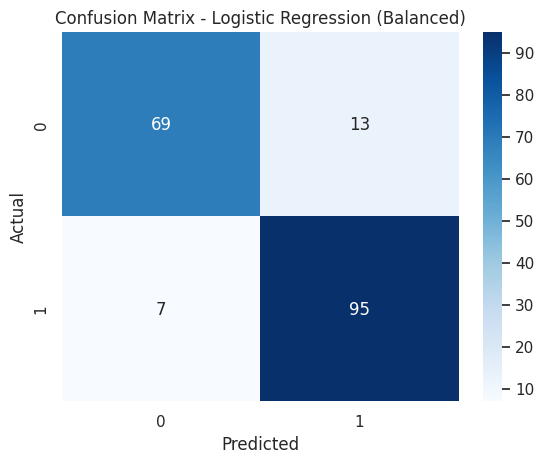

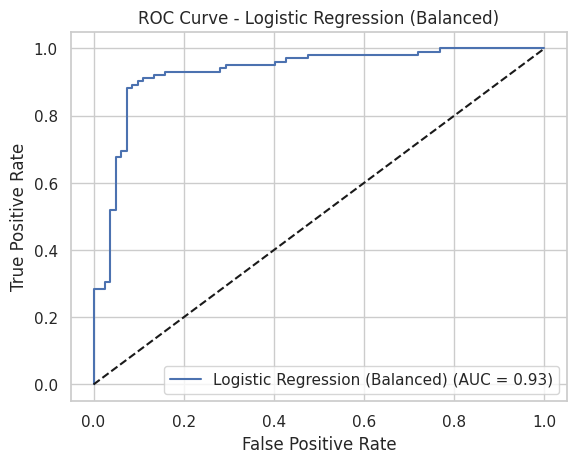


Logistic Regression (SMOTE) Evaluation:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        82
           1       0.90      0.93      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

Accuracy: 0.902 | Precision: 0.896 | Recall: 0.931 | F1-score: 0.913 | ROC AUC: 0.936


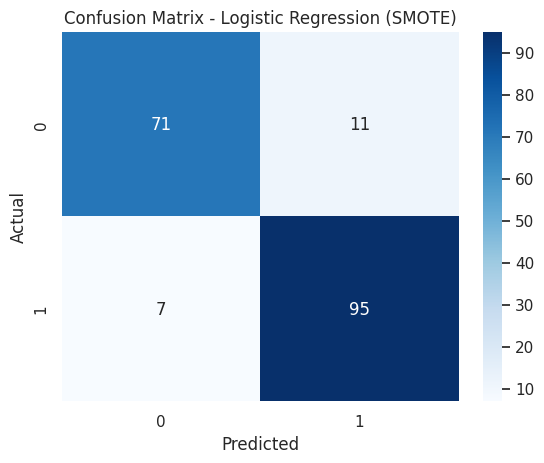

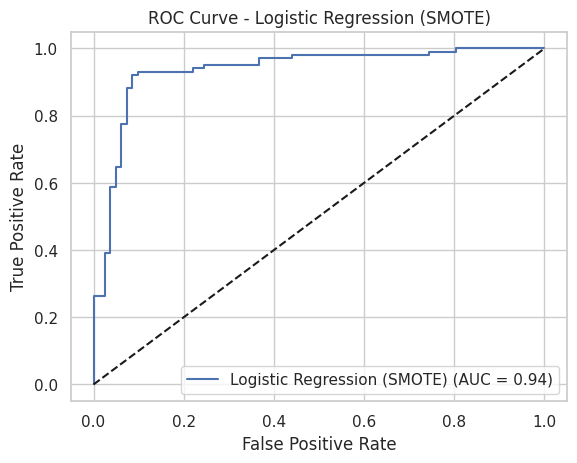


Random Forest (Default) Evaluation:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        82
           1       0.85      0.91      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.86       184
weighted avg       0.86      0.86      0.86       184

Accuracy: 0.859 | Precision: 0.845 | Recall: 0.912 | F1-score: 0.877 | ROC AUC: 0.932


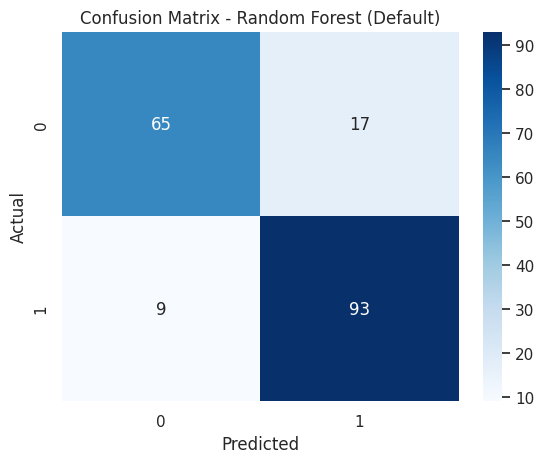

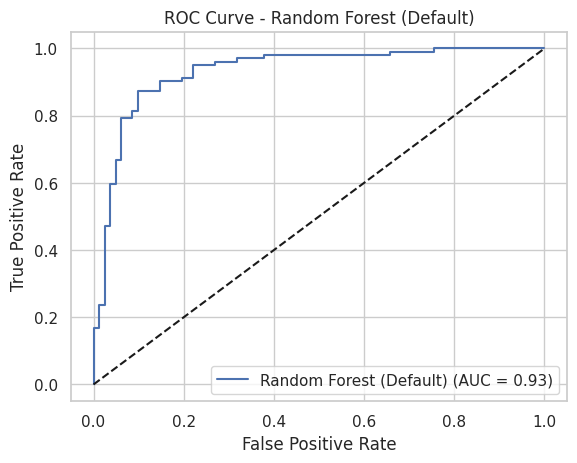


Random Forest (Balanced) Evaluation:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84        82
           1       0.86      0.90      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

Accuracy: 0.864 | Precision: 0.860 | Recall: 0.902 | F1-score: 0.880 | ROC AUC: 0.928


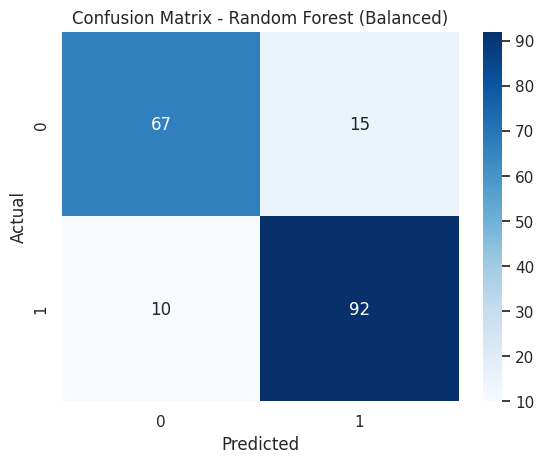

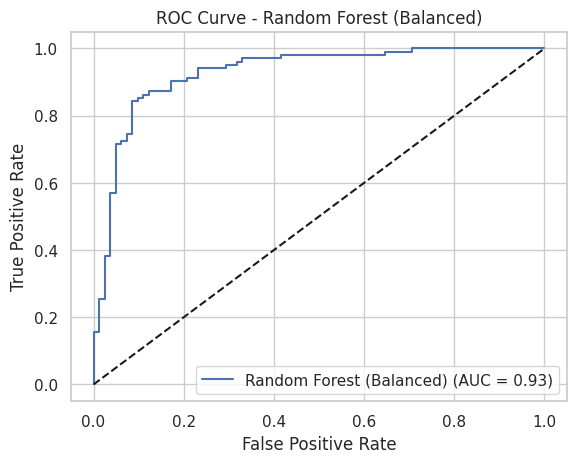


Random Forest (SMOTE) Evaluation:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        82
           1       0.89      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184

Accuracy: 0.880 | Precision: 0.892 | Recall: 0.892 | F1-score: 0.892 | ROC AUC: 0.940


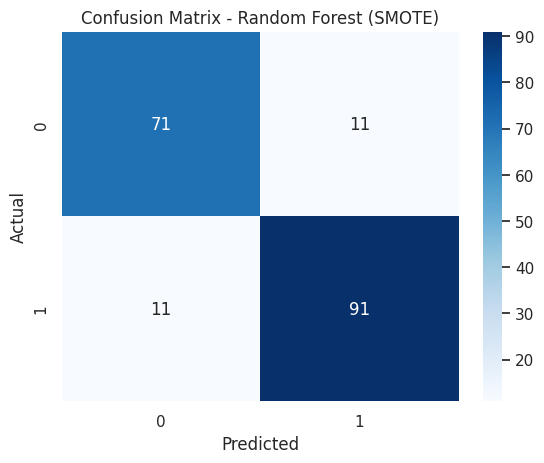

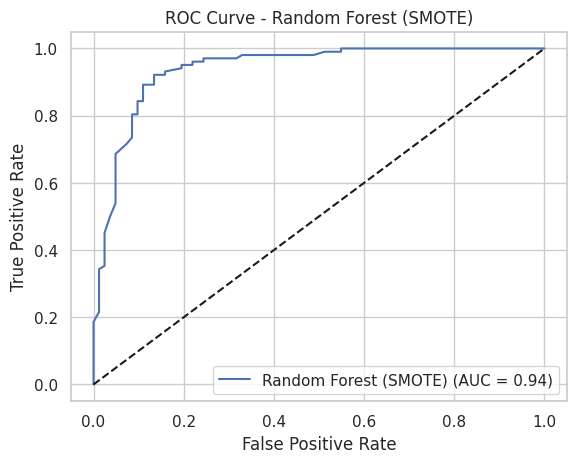


Random Forest (Tuned) Evaluation:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        82
           1       0.89      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184

Accuracy: 0.880 | Precision: 0.892 | Recall: 0.892 | F1-score: 0.892 | ROC AUC: 0.933


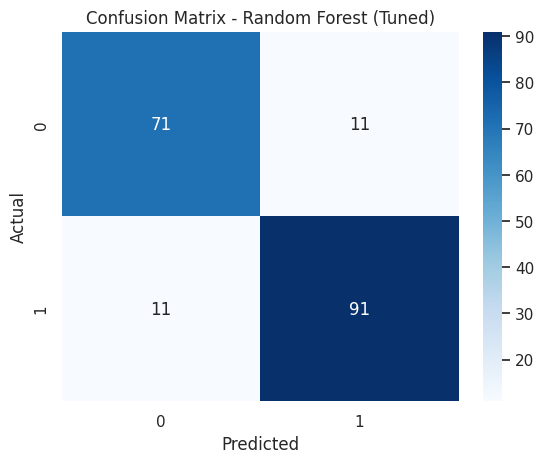

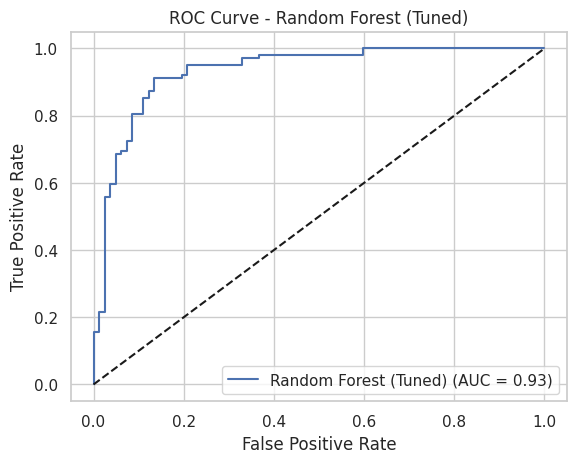


Random Forest (SMOTE Tuned) Evaluation:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        82
           1       0.89      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184

Accuracy: 0.880 | Precision: 0.892 | Recall: 0.892 | F1-score: 0.892 | ROC AUC: 0.938


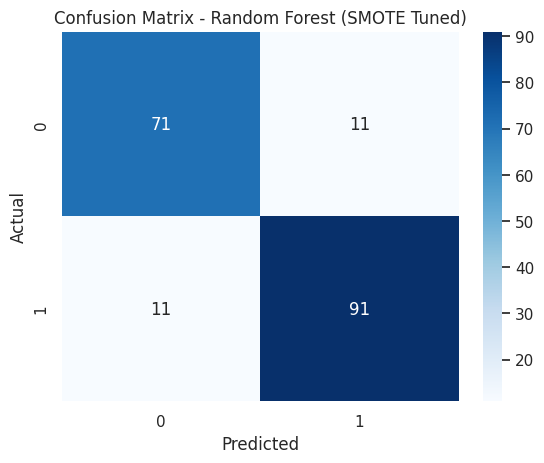

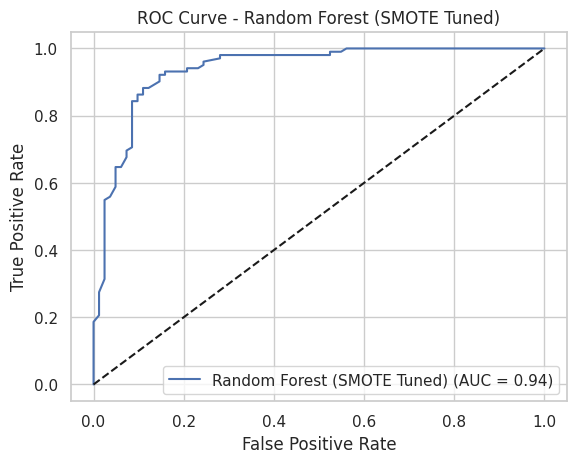

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Deep Learning (MLP) Evaluation:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        82
           1       0.87      0.90      0.88       102

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184

Accuracy: 0.870 | Precision: 0.868 | Recall: 0.902 | F1-score: 0.885 | ROC AUC: 0.932


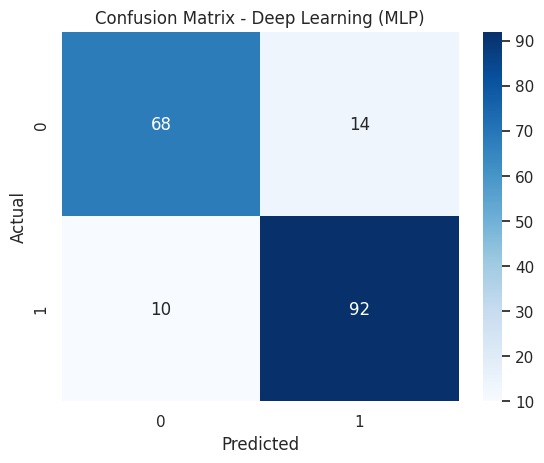

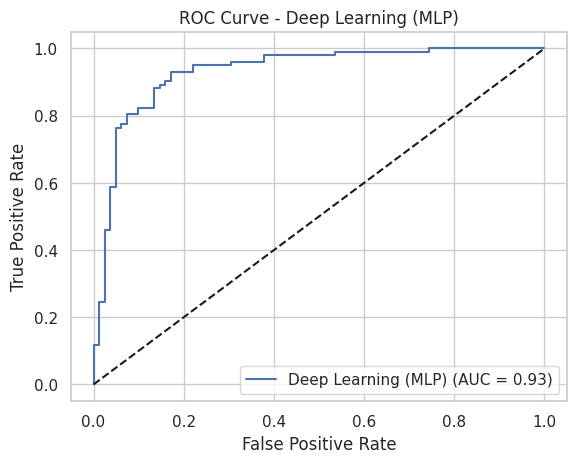

{'Model': 'Deep Learning (MLP)',
 'Accuracy': 0.8695652173913043,
 'Precision': 0.8679245283018868,
 'Recall': 0.9019607843137255,
 'F1-score': 0.8846153846153846,
 'ROC AUC': np.float64(0.9320899091343855)}

In [135]:
# Final evaluation on test set - after model selection

print("\n--- FINAL TEST SET EVALUATION ---\n")

# Logistic Regression (Tuned L2)
y_pred_best_logreg = best_logreg.predict(X_test)
y_prob_best_logreg = best_logreg.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred_best_logreg, y_prob_best_logreg, "Logistic Regression (Tuned L2)")

# Logistic Regression (Balanced)
y_pred_logreg_bal = logreg_balanced.predict(X_test)
y_prob_logreg_bal = logreg_balanced.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred_logreg_bal, y_prob_logreg_bal, "Logistic Regression (Balanced)")

# Logistic Regression (SMOTE)
y_pred_logreg_smote = logreg_smote.predict(X_test)
y_prob_logreg_smote = logreg_smote.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred_logreg_smote, y_prob_logreg_smote, "Logistic Regression (SMOTE)")

# Random Forest (Default)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred_rf, y_prob_rf, "Random Forest (Default)")

# Random Forest (Balanced)
y_pred_rf_bal = rf_balanced.predict(X_test)
y_prob_rf_bal = rf_balanced.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred_rf_bal, y_prob_rf_bal, "Random Forest (Balanced)")

# Random Forest (SMOTE)
y_pred_rf_smote = rf_smote.predict(X_test)
y_prob_rf_smote = rf_smote.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred_rf_smote, y_prob_rf_smote, "Random Forest (SMOTE)")

# Random Forest (Tuned)
y_pred_best_rf = best_rf.predict(X_test)
y_prob_best_rf = best_rf.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred_best_rf, y_prob_best_rf, "Random Forest (Tuned)")

# Random Forest (SMOTE Tuned) --> ÚJ, most kerül hozzá!
y_pred_best_rf_smote = best_rf_smote.predict(X_test)
y_prob_best_rf_smote = best_rf_smote.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred_best_rf_smote, y_prob_best_rf_smote, "Random Forest (SMOTE Tuned)")

# Deep Learning (MLP)
y_prob_dl = model.predict(X_test_dl).flatten()
y_pred_dl = (y_prob_dl >= 0.5).astype(int)
evaluate_model(y_test, y_pred_dl, y_prob_dl, "Deep Learning (MLP)")